In [23]:
# Import required libraries
import numpy as np
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [43]:
# Load dataset
df = pd.read_csv('telco_customer_churn.csv')

# Data cleaning and preprocessing
df.drop(columns=['customerID'], inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

# Convert categorical columns to numeric
label_encoder = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = label_encoder.fit_transform(df[col])


In [45]:
# Handle data imbalance using SMOTE
X = df.drop(columns=['Churn'])
y = df['Churn']
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [47]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

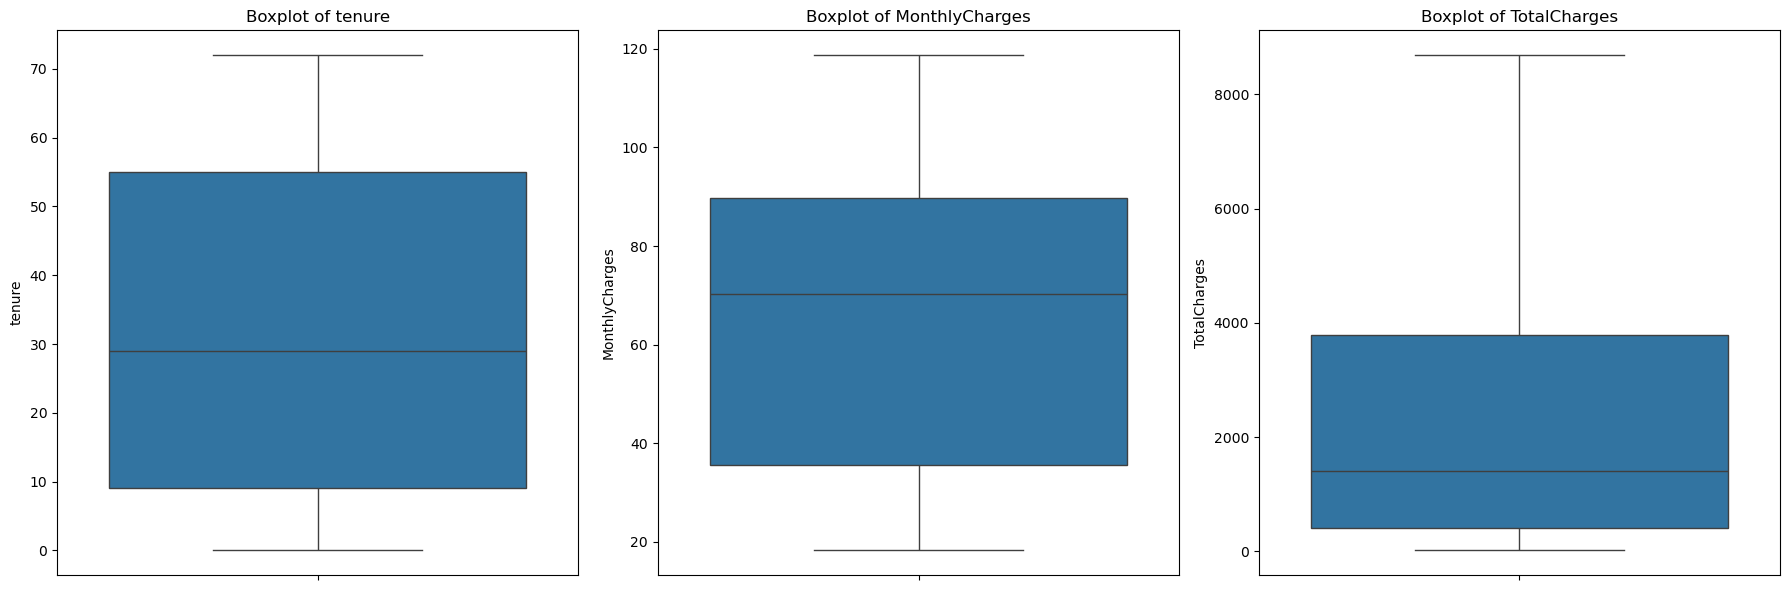

In [49]:
# Visualizations
# Boxplots for numeric columns
columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(18, 6))
for i, col in enumerate(columns):
    plt.subplot(1, len(columns), i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

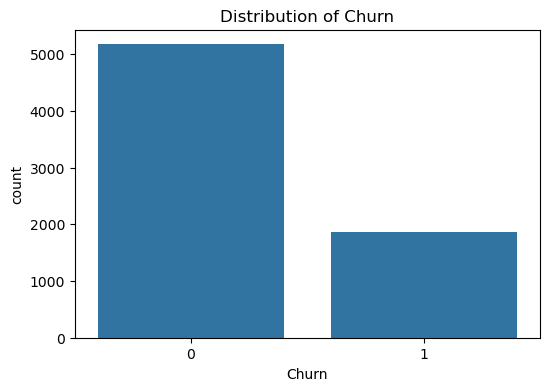

In [51]:
# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn')
plt.title('Distribution of Churn')
plt.show()

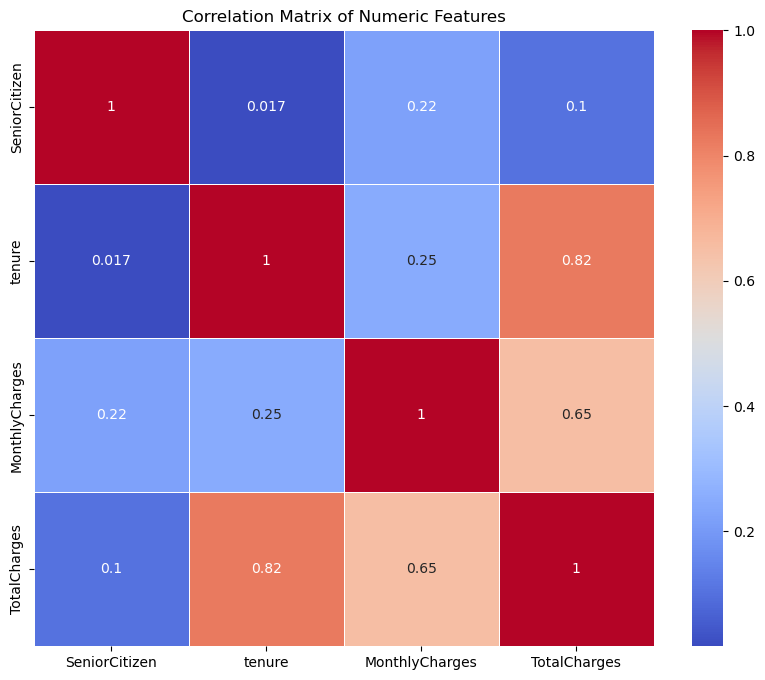

In [53]:
# Correlation heatmap
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

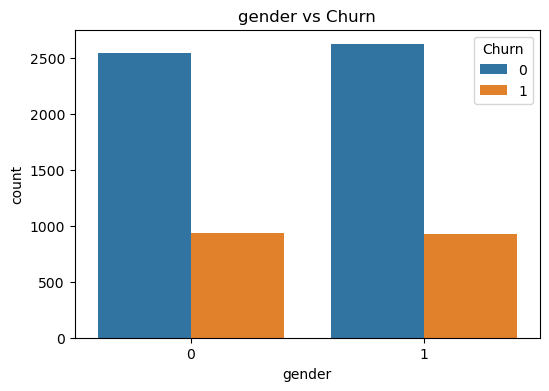

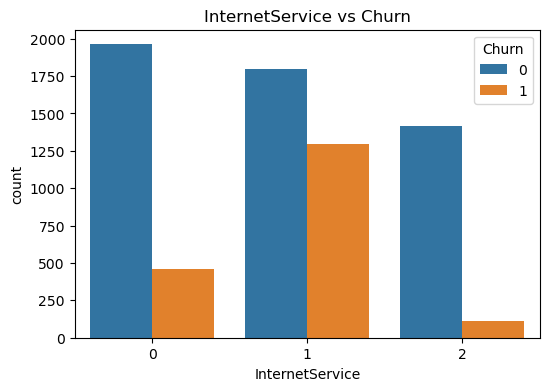

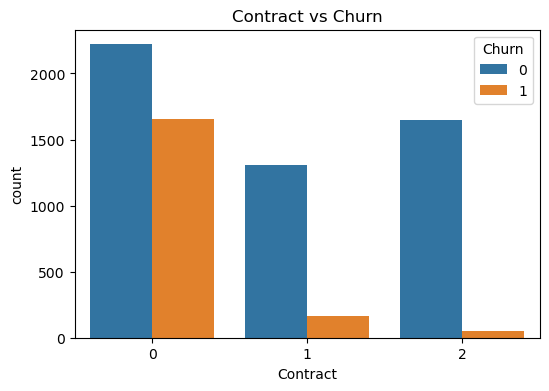

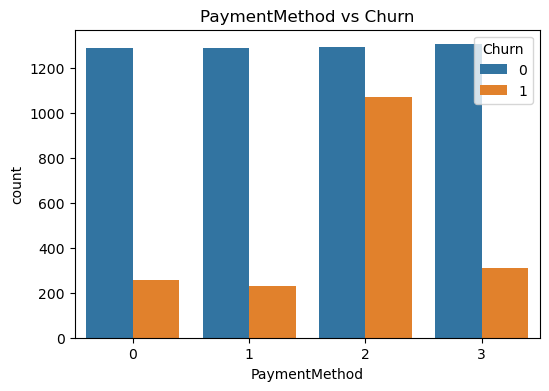

In [55]:
# Churn distribution across categorical variables
categorical_columns = ['gender', 'InternetService', 'Contract', 'PaymentMethod']
for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'{col} vs Churn')
    plt.show()

In [57]:
# Define models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

# Function to evaluate model performance
def evaluate_model_performance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

# Evaluate all models
def evaluate_all_models(models, X_train, y_train, X_test, y_test):
    results = {}
    for model_name, model in models.items():
        results[model_name] = evaluate_model_performance(model, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results).T

# Evaluate models on original dataset
results = evaluate_all_models(models, X_train, y_train, X_test, y_test)
print("Model Performance on SMOTE Dataset:")
print(results)

Model Performance on SMOTE Dataset:
                     Accuracy  Precision    Recall  F1 Score
Naive Bayes          0.786957   0.771429  0.823642  0.796680
Logistic Regression  0.813527   0.795718  0.850334  0.822120
Random Forest        0.856522   0.860153  0.856053  0.858098
XGBoost              0.846377   0.845137  0.853194  0.849146


In [65]:
# Hyperparameter tuning for Random Forest
rf_model = RandomForestClassifier(random_state=42)
param_distributions = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,
                                   n_iter=4, scoring='f1', cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_

# Evaluate the tuned Random Forest
results_best_rf = evaluate_model_performance(best_rf, X_train, y_train, X_test, y_test)
print("\nTuned Random Forest Performance on SMOTE Dataset:")
print(results_best_rf)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Generate SweetViz report
report = sv.compare([X_train_df, "Training Data"], [X_test_df, "Test Data"])
report.show_html('SweetViz_Comparison.html')



Tuned Random Forest Performance on SMOTE Dataset:
{'Accuracy': 0.8545893719806763, 'Precision': 0.8555133079847909, 'Recall': 0.8579599618684461, 'F1 Score': 0.8567348881485007}


                                             |          | [  0%]   00:00 -> (? left)

Report SweetViz_Comparison.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
